In [1]:
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime 
import netCDF4
import xarray as xr

exploring mms data

good resource: https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

In [2]:
# # using NETCDF4

# data_floc = 'mms-data' # directory for data file location
# data_fname = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
# dfile = data_floc+'/'+data_fname+'.nc' # complete path to file

# # get dataset
# mms_dat1 = netCDF4.Dataset(dfile)   # NETCDF4
# # mms_dat1 = xr.open_dataset(dfile) # xarray

# # print vars
# print(mms_dat1.variables.keys()) # NETCDF4
# # mms_dat1.data_vars # xarray

# # individually acces var
# e = mms_dat1.variables['E_EDP'] 
# t = mms_dat1.variables['time'] 

# # get shape, dimension of variable
# print(e.dimensions)
# print(e.shape)

# # pull values from variable
# e = mms_dat1.variables['E_EDI'][:]
# print(e)


In [3]:
# locate data
data_floc = 'mms-data' # directory for data file location
data_fname = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
dfile = data_floc+'/'+data_fname+'.nc' # complete path to file

# read dataset
dat = xr.open_dataset(dfile)

# retrieve EDP
#e = dat["E_EDP"]

# get time
t = dat['time'].values

# get start date in short format
t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y')

# get end date in short format
tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y')

# check
print(f" data start: {t0}, data end: {tf}")


 data start: 09/01/2015, data end: 12/31/2018


In [4]:
# isolate E-field from diff. MMS instruments
edp = dat['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']})
edi = dat['E_EDI']
dis = dat['E_DIS']
des = dat['E_DES']


# # pull values
# e = e.loc[:,'x'].values
# # remove values greater than +/-1000 [mV/m]
# e[abs(e) >= 1000] = np.nan
# # plots
#e.loc[:,'x'].plot()
#plt.plot(t,ex)



[Text(16679.0, 0, '2015-09-01'),
 Text(16801.0, 0, '2016-01-01'),
 Text(16922.0, 0, '2016-05-01'),
 Text(17045.0, 0, '2016-09-01'),
 Text(17167.0, 0, '2017-01-01'),
 Text(17287.0, 0, '2017-05-01'),
 Text(17410.0, 0, '2017-09-01'),
 Text(17532.0, 0, '2018-01-01'),
 Text(17652.0, 0, '2018-05-01'),
 Text(17775.0, 0, '2018-09-01'),
 Text(17897.0, 0, '2019-01-01')]

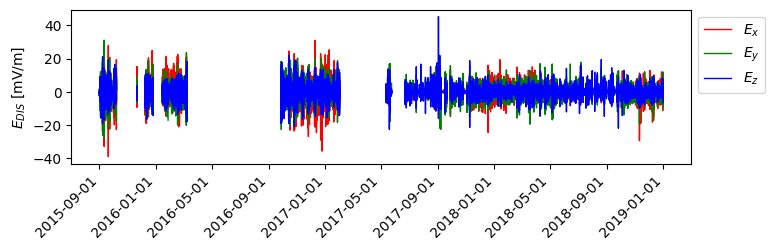

In [5]:

def plot_efield_overview(ax, edat, t):
    
    instr_name = str(edat.name[-3:7])   # instrument name
    instr_ltX = "$E_{"+instr_name+"}$"  # name in LaTex formatting
    
    # pull data
    ex = edat.loc[:,'x'].values # Ex
    ey = edat.loc[:,'y'].values # Ey
    ez = edat.loc[:,'z'].values # Ez
    
    # remove outlying/bad values
    for arr in [ex,ey,ez]:
        arr[abs(arr) >= 1000] = np.nan
    
    # plot E-field over time
    ax.plot(t,ex, c='r', linewidth=1, label='$E_x$')
    ax.plot(t,ey, c='g', linewidth=1, label='$E_y$')
    ax.plot(t,ez, c='b', linewidth=1, label='$E_z$')
    ax.set_ylabel(f"{instr_ltX} [mV/m]")
    
    # x-axis tick label rotation to fit length of dates
    # ax.set_xticks(ax.get_xticks())
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # plot legend
    ax.legend(bbox_to_anchor=(1, 1))
        

# (A/N) run for DIS instrument
fig, ax = plt.subplots(1, figsize=(8, 2))
plot_efield_overview(ax,dis,t)
# x-axis tick label rotation to fit length of dates
#ax.set_xticks(ax.get_xticks())
ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


In [5]:
# (A/N) this code creates plot for all MMS instruments;
# (A/N) runs a bit slow!

# fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))
# fig.tight_layout()
# # fig.suptitle(f'Overview of {sdate} Storm')
# plot_efield_overview(ax[0],edi,t)
# plot_efield_overview(ax[1],edp,t)
# plot_efield_overview(ax[2],dis,t)
# plot_efield_overview(ax[3],des,t)

# # x-axis tick label rotation to fit length of dates
# # ax[3].set_xticks(ax[3].get_xticks().tolist())
# ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha='right')
    


In [11]:

def plot_efield_comp(axs, ef1, ef2, c='k', hex=False, **kwargs):
    
    instr1 = "$E_{"+str(ef1.name[-3:7])+"}$" # instrument 1 name
    instr2 = "$E_{"+str(ef2.name[-3:7])+"}$" # instrument 2 name
    
    # get coordinates
    ef1_coord = [ef1.loc[:,'x'].values, ef1.loc[:,'y'].values, ef1.loc[:,'z'].values]
    ef2_coord = [ef2.loc[:,'x'].values, ef2.loc[:,'y'].values, ef2.loc[:,'z'].values]
    coord = ['x','y','z']
    
    # remove outliers
    for arr in ef1_coord:
        arr[abs(arr) >= 1000] = np.nan
        
    for arr in ef2_coord:
        arr[abs(arr) >= 1000] = np.nan
    
    # scatter plot: efield comparison
    for i in range(0,3):
        if hex == True:
            axs[i].hexbin(ef1_coord[i], ef2_coord[i], gridsize=(150, 150), bins="log")
        else:
            axs[i].scatter(ef1_coord[i], ef2_coord[i], marker='x',color=c,linewidths=0.5, **kwargs)
        axs[i].set_xlabel(f"{instr1}$_{{,{coord[i]}}}$ [mV/m]")
        axs[i].set_ylabel(f"{instr2}$_{{,{coord[i]}}}$ [mV/m]")

    # identity line
    for ax in axs:
        ax.plot([0,1],[0,1], color='r', linewidth=1, alpha=1, transform=ax.transAxes)
        
    # enforce square-shaped plots
    for ax in axs:
        ax.set_box_aspect(1)

    # alternative, makes line start/stop just before end of plot
    # for ax in axs:
    #     lims = [
    #     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #     ]

    #     # identity line
    #     ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    # generate caption
    t = ef1['time'].values
    t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y')
    tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y')
    print(f"Comparison of electric field values for the {ef1.name[-3:7]} and {ef2.name[-3:7]} MMS instruments from {t0} to {tf}. E-field values in units [mV/m]." )

# example run
fig, axs = plt.subplots(1,3, figsize=(10,10))
plot_efield_comp(axs, edi, edp, hex=True)
fig.tight_layout()

In [9]:
'''Making a merged plot
'''

# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_mms1a = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
data_fname_mms1b = 'mms1_imef_srvy_l2_5sec_20190101000000_20220901000000'
data_fname_mms2a = 'mms2_imef_srvy_l2_5sec_20150901000000_20190101000000'
data_fname_mms2b = 'mms2_imef_srvy_l2_5sec_20190101000000_20220901000000'

dfile_mms1a = data_floc+'/'+data_fname_mms1a+'.nc' # complete path to file
dfile_mms2a = data_floc+'/'+data_fname_mms1a+'.nc' # complete path to file

# read dataset
dat_mms1a = xr.open_dataset(dfile_mms1a)
dat_mms2a = xr.open_dataset(dfile_mms2a)

# isolate E-field from diff. MMS instruments
edi_1a = dat_mms1a['E_EDI']
dis_1a = dat_mms1a['E_DIS']
edi_2a = dat_mms2a['E_EDI']
dis_2a = dat_mms2a['E_DIS']


# fig, axs = plt.subplots(1,3, figsize=(10,10))
# plot_efield_comp(axs, edi_1a, dis_1a, label="mms1")
# plot_efield_comp(axs, edi_2a, dis_2a, c='b', label="mms1")
# plt.legend()
# # for ax in axs:
# #     ax.legend()
# fig.tight_layout()

Comparison of electric field values for the EDI and DIS MMS instruments from 09/01/2015 to 12/31/2018. E-field values in units [mV/m].


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Comparison of electric field values for the EDI and DIS MMS instruments from 09/01/2015 to 12/31/2018. E-field values in units [mV/m].
Error in callback <function _draw_all_if_interactive at 0x117629080> (for post_execute):


KeyboardInterrupt: 